In [426]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [427]:
df = pd.read_csv('cars.csv')
df.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [428]:
df.dtypes

mpg             float64
 cylinders        int64
 cubicinches     object
 hp               int64
 weightlbs       object
 time-to-60       int64
 year             int64
 brand           object
dtype: object

In [429]:
df[' cubicinches'] = pd.to_numeric(df[' cubicinches'], errors='coerce')
df[' weightlbs'] = pd.to_numeric(df[' weightlbs'], errors='coerce')

In [430]:
df.isna().sum()

mpg             0
 cylinders      0
 cubicinches    2
 hp             0
 weightlbs      3
 time-to-60     0
 year           0
 brand          0
dtype: int64

In [431]:
df.dropna(inplace=True)

In [432]:
df.duplicated().sum()

np.int64(0)

In [433]:
mappings = {}
for col in df.select_dtypes(include='object'):
    unique_labels = df[col].unique()
    value_to_label = {key: value for value, key in enumerate(unique_labels)}
    mappings[col] = value_to_label
    df[col] = df[col].map(value_to_label)

In [434]:
x = df.drop(columns = ' brand')
y = df[' brand']

In [435]:
# x

In [436]:
np.random.seed(0)
train_size = int(len(x) * 0.8)
idx = np.random.permutation(len(x))

x_train, x_test = x.iloc[idx[:train_size]], x.iloc[idx[train_size:]]
y_train, y_test = y.iloc[idx[:train_size]], y.iloc[idx[train_size:]]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(204, 7)
(52, 7)
(204,)
(52,)


In [437]:
from sklearn.neighbors import NearestNeighbors

def custom_smote(x_train, y_train, sampling_strategy, random_state=None):
    np.random.seed(random_state)
    
    # Separate the minority classes
    unique_classes = np.unique(y_train)
    minority_classes = {cls: np.where(y_train == cls)[0] for cls in sampling_strategy.keys()}
    
    # Prepare the new samples storage
    new_samples = []
    new_labels = []

    for cls, n_samples in sampling_strategy.items():
        # Select the minority class samples
        x_minority = x_train[minority_classes[cls]]
        
        # Fit the nearest neighbors model
        nn = NearestNeighbors(n_neighbors=5)
        nn.fit(x_minority)
        
        for _ in range(n_samples):
            # Randomly choose a minority sample
            idx = np.random.randint(0, len(x_minority))
            x_sample = x_minority[idx].reshape(1, -1)
            
            # Find the k-nearest neighbors for this sample
            neighbors = nn.kneighbors(x_sample, return_distance=False).flatten()
            
            # Choose one of the neighbors randomly
            neighbor_idx = neighbors[np.random.randint(1, len(neighbors))]
            x_neighbor = x_minority[neighbor_idx]
            
            # Create a synthetic sample
            diff = x_neighbor - x_sample
            gap = np.random.rand()
            synthetic_sample = x_sample + gap * diff
            
            new_samples.append(synthetic_sample.flatten())
            new_labels.append(cls)
    
    # Combine original and new samples
    x_resampled = np.vstack([x_train] + new_samples)
    y_resampled = np.hstack([y_train] + new_labels)
    
    return x_resampled, y_resampled

# Example usage
x_resampled, y_resampled = custom_smote(x_train.values, y_train.values, {1: 90, 2: 90}, random_state=42)

# Combine the oversampled data back into a DataFrame
df_train = pd.concat([pd.DataFrame(x_resampled, columns=x_train.columns), pd.DataFrame(y_resampled, columns=[' brand'])], axis=1)

print(df_train[' brand'].value_counts())

 brand
0    136
1    125
2    123
Name: count, dtype: int64


In [438]:
x_train = df_train.drop(columns=' brand')
y_train = df_train[' brand']

In [439]:
from collections import Counter
import random

In [440]:
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

def gini_index(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

def entropy(y):
    m = len(y)
    return -sum((np.sum(y == c) / m) * np.log2(np.sum(y == c) / m) for c in np.unique(y))

def grow_tree(X, y, depth=0, max_depth=5, min_samples_split=2, min_samples_leaf=1, criterion='gini', splitter='best'):
    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]  # jumlah per kelas
    predicted_class = np.argmax(num_samples_per_class)  # kelas yang paling banyak
    node = Node(
        gini=gini_index(y) if criterion == 'gini' else entropy(y),
        num_samples=len(y),
        num_samples_per_class=num_samples_per_class,
        predicted_class=predicted_class,
    )

    if depth < max_depth and len(y) >= min_samples_split:
        idx, thr = best_split(X, y, min_samples_leaf, criterion, splitter)
        if idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]
            node.feature_index = idx
            node.threshold = thr
            node.left = grow_tree(X_left, y_left, depth + 1, max_depth, min_samples_split, min_samples_leaf, criterion, splitter)
            node.right = grow_tree(X_right, y_right, depth + 1, max_depth, min_samples_split, min_samples_leaf, criterion, splitter)
    return node

def best_split(X, y, min_samples_leaf, criterion='gini', splitter='best'):
    m, n = X.shape
    if m <= 1:
        return None, None

    num_parent = [np.sum(y == c) for c in np.unique(y)]
    best_gini = 1.0 - sum((num / m) ** 2 for num in num_parent) if criterion == 'gini' else entropy(y)
    best_idx, best_thr = None, None

    if splitter == 'best':
        feature_indices = range(n)
    elif splitter == 'random':
        np.random.seed(0)
        feature_indices = np.random.choice(n, size=max(1, n // 2), replace=False)
    else:
        raise ValueError("splitter must be 'best' or 'random'")

    for idx in feature_indices:
        thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
        num_left = Counter()
        num_right = Counter(num_parent)
        for i in range(1, m):
            c = classes[i - 1]
            num_left[c] += 1
            num_right[c] -= 1
            if i < min_samples_leaf or m - i < min_samples_leaf:
                continue
            gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in num_left) if criterion == 'gini' else entropy(list(num_left.elements()))
            gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in num_right) if criterion == 'gini' else entropy(list(num_right.elements()))
            gini = (i * gini_left + (m - i) * gini_right) / m

            if thresholds[i] == thresholds[i - 1]:
                continue

            if gini < best_gini:
                best_gini = gini
                best_idx = idx
                best_thr = (thresholds[i] + thresholds[i - 1]) / 2
    return best_idx, best_thr

In [441]:
class DecisionTreeClassifierFromScratch:
    def __init__(self, max_depth=5, min_samples_leaf=1, criterion='gini', splitter='best'):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.splitter = splitter
        self.tree = None

    def fit(self, X, y):
        self.tree = grow_tree(X, y, max_depth=self.max_depth, min_samples_split=2, min_samples_leaf=self.min_samples_leaf, criterion=self.criterion, splitter=self.splitter)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [442]:
model = DecisionTreeClassifierFromScratch(max_depth=4, min_samples_leaf=10, criterion='entropy', splitter='best')
model.fit(x_train.values, y_train.values)
y_pred = model.predict(x_test.values)
accuracy = np.mean(y_test == y_pred)
print(f'Accuracy: {accuracy * 100 :.2f}%')

Accuracy: 67.31%


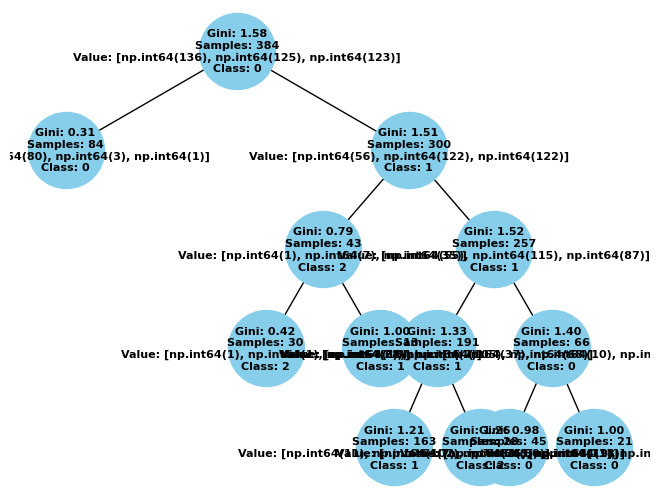

In [443]:
import networkx as nx
import matplotlib.pyplot as plt

def add_edges(graph, node, pos=None, x=0, y=0, layer=1):
    if pos is None:
        pos = {}
    pos[node] = (x, y)
    if node.left:
        graph.add_edge(node, node.left)
        l = x - 1 / layer
        pos = add_edges(graph, node.left, x=l, y=y-1, pos=pos, layer=layer+1)
    if node.right:
        graph.add_edge(node, node.right)
        r = x + 1 / layer
        pos = add_edges(graph, node.right, x=r, y=y-1, pos=pos, layer=layer+1)
    return pos

def draw_tree(tree):
    graph = nx.DiGraph()
    pos = add_edges(graph, tree)
    labels = {node: f'Gini: {node.gini:.2f}\nSamples: {node.num_samples}\nValue: {node.num_samples_per_class}\nClass: {node.predicted_class}' for node in pos}
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=3000, node_color='skyblue', font_size=8, font_weight='bold', arrows=False)
    plt.show()

draw_tree(model.tree)

In [444]:
df[df[' brand'] == 0].head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,0
2,17.0,8,302.0,140,3449.0,11,1971,0
3,15.0,8,400.0,150,3761.0,10,1971,0
4,30.5,4,98.0,63,2051.0,17,1978,0
5,23.0,8,350.0,125,3900.0,17,1980,0


In [445]:
df[df[' brand'] == 1].head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
1,31.9,4,89.0,71,1925.0,14,1980,1
8,25.4,5,183.0,77,3530.0,20,1980,1
11,34.3,4,97.0,78,2188.0,16,1981,1
19,24.0,4,107.0,90,2430.0,15,1971,1
21,21.5,4,121.0,110,2600.0,13,1978,1


In [446]:
df[df[' brand'] == 2].head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
9,37.7,4,89.0,62,2050.0,17,1982,2
10,34.0,4,108.0,70,2245.0,17,1983,2
16,31.8,4,85.0,65,2020.0,19,1980,2
18,24.0,4,113.0,95,2278.0,16,1973,2
20,37.2,4,86.0,65,2019.0,16,1981,2


In [447]:
# from customtkinter import *

In [448]:
# def gui_call():
#     baseplate = CTk()
#     baseplate.title('Decision tree GUI')
#     set_appearance_mode('dark')
#     baseplate.geometry('650x550')
    
#     def answer():
#         try:
#             raw_data = np.array([
#                 float(entry_input1.get()),
#                 int(entry_input2.get()),
#                 float(entry_input3.get()),
#                 float(entry_input4.get()),
#                 float(entry_input5.get()),
#                 float(entry_input6.get()),
#                 int(entry_input7.get()),
#             ]).reshape(1, -1)
#             print(raw_data)
#             predict = model.predict(raw_data)[0]
#             pred_dict = {0 : 'US', 1 :' Europe.', 2:' Japan.'}
#             print(pred_dict[predict])
#             label_output.configure(text=f'Prediksi {pred_dict[predict]}', text_color='light green',font=('Arial',14))
            
#         except Exception as e:
#             print(f'Error occured {e}')
#             label_output.configure(text=f'Error occured {e}', text_color='red',font=('Arial',14))
            
    
#     label_title = CTkLabel(text='Car Country Checker',master=baseplate, font=('Arial', 14))
#     label_title.place(relx=0.4,rely=0.1)
    
#     label_input1 = CTkLabel(text='Masukkan nilai MPG',master=baseplate, font=('Arial', 12))
#     label_input1.place(relx=0.05,rely=0.2)
#     entry_input1 = CTkEntry(placeholder_text='Masukkan nilai MPG',master=baseplate, font=('Arial', 12), width=300)
#     entry_input1.place(relx=0.30,rely=0.2) 
    
#     label_input2 = CTkLabel(text='Masukkan jumlah cylinders',master=baseplate, font=('Arial', 12))
#     label_input2.place(relx=0.05,rely=0.28)
#     entry_input2 = CTkEntry(placeholder_text='Masukkan jumlah cylinders mobil',master=baseplate, font=('Arial', 12), width=300)
#     entry_input2.place(relx=0.30,rely=0.28)
    
#     label_input3 = CTkLabel(text='Masukkan jumlah in^3',master=baseplate, font=('Arial', 12))
#     label_input3.place(relx=0.05,rely=0.36)
#     entry_input3 = CTkEntry(placeholder_text='Masukkan jumlah in^3',master=baseplate, font=('Arial', 12), width=300)
#     entry_input3.place(relx=0.30,rely=0.36)
    
#     label_input4 = CTkLabel(text='Masukkan jumlah horsepower',master=baseplate, font=('Arial', 12))
#     label_input4.place(relx=0.05,rely=0.44)
#     entry_input4 = CTkEntry(placeholder_text='Masukkan jumlah horsepower',master=baseplate, font=('Arial', 12), width=300)
#     entry_input4.place(relx=0.30,rely=0.44)
    
#     label_input5 = CTkLabel(text='Masukkan berat mobil lbs',master=baseplate, font=('Arial', 12))
#     label_input5.place(relx=0.05,rely=0.52)
#     entry_input5 = CTkEntry(placeholder_text='Masukkan berat mobil lbs',master=baseplate, font=('Arial', 12), width=300)
#     entry_input5.place(relx=0.30,rely=0.52)
    
#     label_input6 = CTkLabel(text='Masukkan time to 60',master=baseplate, font=('Arial', 12))
#     label_input6.place(relx=0.05,rely=0.60)
#     entry_input6 = CTkEntry(placeholder_text='Masukkan time to 60',master=baseplate, font=('Arial', 12), width=300)
#     entry_input6.place(relx=0.30,rely=0.60)
    
#     label_input7 = CTkLabel(text='Masukkan tahun mobil dibuat',master=baseplate, font=('Arial', 12))
#     label_input7.place(relx=0.05,rely=0.68)
#     entry_input7 = CTkEntry(placeholder_text='Masukkan tahun mobil dibuat',master=baseplate, font=('Arial', 12), width=300)
#     entry_input7.place(relx=0.30,rely=0.68)
    
#     btn = CTkButton(text='Enter' ,master=baseplate, fg_color='green', command=answer)
#     btn.place(relx=0.3,rely=0.76)
    
#     label_output = CTkLabel(master=baseplate, text='', font=('Arial',14), text_color='red')
#     label_output.place(relx=0.3,rely=0.85)

#     baseplate.mainloop()

In [449]:
# gui_call()